In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import numpy as np
import os
from tqdm import tqdm
import itertools
%matplotlib inline

In [265]:
#0 Init varibles - edit here
os.environ['project_ID'] = 'Project_AAHZ_L2_DAP_seqpool'
os.environ['control'] = 'Halovector_S35_L002_R1_001'

# Do not change below
os.environ['path'] = '/home/jiyindna/Desktop/Dubiosys/Data/Dapseq'
os.environ['file_path'] = '/home/jiyindna/Desktop/Dubiosys/Data/Dapseq/'+os.environ['project_ID']
os.environ['gempath'] = '/home/jiyindna/Desktop/Dubiosys/Genetools/gem'


In [256]:
#0 Init varibles - edit here
os.environ['project_ID'] = '01_01_2019_Sarah'
os.environ['control'] = 'CONTROL-PE-P70-1_S3_R1_001'

# Do not change below
os.environ['path'] = '/home/jiyindna/Desktop/Dubiosys/Data/Dapseq'
os.environ['file_path'] = '/home/jiyindna/Desktop/Dubiosys/Data/Dapseq/'+os.environ['project_ID']
os.environ['gempath'] = '/home/jiyindna/Desktop/Dubiosys/Genetools/gem'


In [257]:
#1 Trim raw fastq files 
File_list = os.listdir(os.environ['project_ID']+'/')
!mkdir -p $project_ID/Trimmed_output
for file in tqdm(File_list):
    if file.endswith(".gz"):
        os.environ['input_name'] = os.path.join(os.environ['project_ID'], file)
        os.environ['output_name'] = os.path.join(os.environ['project_ID']+"/Trimmed_output", file)
        !java -jar /home/jiyindna/Desktop/Dubiosys/Genetools/Trimmomatic-0.36/trimmomatic-0.36.jar  \
        SE -phred33 $input_name $output_name \
        ILLUMINACLIP:TruSeq3-SE:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36 

100%|██████████| 13/13 [00:00<00:00, 20622.52it/s]


In [289]:
#2 Getting sample names for downstream processes
File_list = os.listdir(os.environ['project_ID']+"/Trimmed_output/")
Sample_list = [item.split('.')[0] for item in File_list if item.endswith(".gz")]

In [290]:
#3 In this step (3) and the following step (4), you can manualy delete some of the samples that you do not wish to analyse
with open(os.environ['project_ID']+"/Trimmed_output/filelist.txt","w") as f:
    for item in Sample_list:
        #if item.endswith(".gz"):
        f.write("%s\n" % item)

In [291]:
#4 Edit your file then run this step 
with open(os.environ['project_ID']+"/Trimmed_output/filelist.txt","r") as f:
        Sub_sample_list = [item.split('\n')[0] for item in tqdm(f)]

35it [00:00, 17360.53it/s]


In [ ]:
#5 QC the trimmmed files
!mkdir -p ./$project_ID/Trimmed_output/Fastqc
for item in File_list:
    os.environ['item'] = item
    if item.endswith(".gz"):
        !fastqc ./$project_ID/Trimmed_output/$item \
        --outdir=./$project_ID/Trimmed_output/Fastqc/

In [343]:
!multiqc ./$project_ID/Trimmed_output/Fastqc 
!zip -r $project_ID.zip multiqc_report.html ./multiqc_data
!rm -r ./multiqc_data
!rm multiqc_report.html

[WARNING]         multiqc : MultiQC Version v1.7 now available!
[INFO   ]         multiqc : This is MultiQC v1.6
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching './Project_AAHZ_L2_DAP_seqpool/Trimmed_output/Fastqc'
Searching 70 files..  [####################################]  100%
[INFO   ]          fastqc : Found 35 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : multiqc_report.html
[INFO   ]         multiqc : Data        : multiqc_data
[INFO   ]         multiqc : MultiQC complete
updating: multiqc_report.html (deflated 63%)
updating: multiqc_data/ (stored 0%)
updating: multiqc_data/multiqc_sources.txt (deflated 91%)
updating: multiqc_data/multiqc_fastqc.txt (deflated 78%)
updating: multiqc_data/multiqc.log (deflated 89%)
updating: multiqc_data/multiqc_data.json (deflated 93%)
updating: multiqc_data/multiqc_general_stats.txt (deflated 64%)


In [31]:
# Create index for reference genome - Only need to do this once if not done yet
# !bwa index -a bwtsw Genome_ref/PT_Chr_masked.fa

In [291]:
# Mask repeats using - run once to create genome reference
!convert2bed -i gff -o bed <$path/Genome_ref/Phatr2_RepeatMasker_Maumus_Pt_TEs.gff> $path/Genome_ref/Phatr2_RepeatMasker_Maumus_Pt_TEs.bed
!bedtools maskfasta -fi $path/Genome_ref/PT_Chr_only.fa -bed $path/Genome_ref/Phatr2_RepeatMasker_Maumus_Pt_TEs.bed -fo $path/Genome_ref/PT_Chr_masked.fa

In [270]:
#6 Seq alignment and write sam files
# https://arxiv.org/abs/1303.3997

# In case of bwa aln
# -o set gap open to 0 
# -B set mismatch penalty .75 * exp(-log(4) * B) to 0.001 when V = 11

#In case of bwa mem
# -k Minimum seed length. Matches shorter than INT will be missed.
# -B Mismatch penalty. The sequence error rate is approximately: {.75 * exp[-log(4) * B/A]}
# -O Gap open penalty.[6]

# !mkdir -p $file_path/Sai_index
!mkdir -p $file_path/Sam_File
for item in tqdm(Sub_sample_list):
    os.environ['sample_ID'] = item
    '''!bwa aln -t 8 -o 0 -M 11 $path/Genome_ref/PT_Chr_only.fa \
        $file_path/Trimmed_output/$sample_ID.fastq.gz > $file_path/Sai_index/$sample_ID.sai'''
    
    '''!bwa samse -f $file_path/Sam_File/$sample_ID.sam \
        $path/Genome_ref/PT_Chr_only.fa\
        $file_path/Sai_index/$sample_ID.sai \
        $file_path/Trimmed_output/$sample_ID.fastq.gz'''
    
    # Note bwa mem does not take masked genome
    !bwa mem -t 8 -k 60 -B 7 -O 6 -v 0 $path/Genome_ref/PT_Chr_only.fa \
        $file_path/Trimmed_output_john/$sample_ID.fastq.gz > $file_path/Sam_File/$sample_ID.sam
    
    

100%|██████████| 46/46 [00:10<00:00,  4.19it/s]


In [ ]:
#7 filtering flag set at 4 
!mkdir -p $file_path/Sam_sorted

# reuse functions in cmd_path created by John

for item in tqdm(Sub_sample_list):
    os.environ['sample_ID'] = item
    print(item)
    # remove unmapped F 4 and PCR 400 sequences (first clean), then remove dup seq in fasta file (second clean)  
    !samtools view -@ 8 -h -F 4 -q 30 -u -S $file_path/Sam_File/$sample_ID.sam \
    | samtools sort -@ 8 - $file_path/Sam_sorted/$sample_ID._temp
    
    !samtools rmdup -s $file_path/Sam_sorted/$sample_ID._temp.bam $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam 
    
    !samtools index $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam 

    
    '''!bam_to_gff.pl $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
    > $file_path/gff/$sample_ID.gff

    !gff_to_bed.pl $file_path/gff/$sample_ID.gff > $file_path/bed/$sample_ID.bed'''
    
    
    #!samtools bam2fq $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam | seqtk seq -A - > $file_path/fasta/$sample_ID.fa

    #!fastx_collapser < $file_path/fasta/$sample_ID.fa > $file_path/fasta/$sample_ID.unique.fa

In [ ]:
# Vis singals
!mkdir -p $file_path/bigWig
for item in tqdm(Sub_sample_list):
    os.environ['sample_ID'] = item
    
    !bamCoverage -b $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam\
    --normalizeUsing BPM \
    -p 8 --extendReads 300 \
    -o $file_path/bigWig/$sample_ID.bw


In [ ]:
# Compare bam files and target peak regions
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !bamCompare  -b1 $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
        -b2 $file_path/Sam_sorted/$control._mapped_sorted.bam \
        -o $file_path/bigWig/$sample_ID.peaks.bw \
        -p 8 --binSize 200 --operation ratio --scaleFactorsMethod SES -n 1000

In [ ]:
# MACS2 for peak calling
#-B store all details
# -q/--qvalue The qvalue (minimum FDR) cutoff to call significant regions.
'''Default is 0.05. For broad marks, you can try 0.05 as cutoff. 
Q-values are calculated from p-values using Benjamini-Hochberg procedure.'''


for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !macs2 callpeak -t $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
        -c $file_path/Sam_sorted/$control._mapped_sorted.bam \
        -f BAM --outdir $file_path/MACS -g 1.6e7 -n $sample_ID -B -q 0.01 -m 2 50

In [ ]:
#GEM tool for peak calling and motif model creation - use BAM file
# force q value to be 0.001, q = 3, 0.01, q =2
# Only to use GPS data here

# The p-value of the motif occurence. 
'''The p-value is the probability of a random sequence of the same 
length as the motif matching that position of the sequence with a 
score at least as good.'''

# The q-vlavlue of the motif occurence. 
'''The q-value is the estimated false discovery rate if the occurrence 
is accepted as significant.''' 

#The width (bp) to smooth the read distribution. 
'''If it is set to -1, there will be no smoothing (default=30). 
For ChIP-exo, use a smaller number (say 3 or 5) to achieve higher spatial accuracy.'''

# Fold (IP/Control) cutoff to filter predicted events (default=3)
# Depending on the sequencing depth, the sample read

# Proc. Natl Acad. Sci. USA (2003) 100:9440–9445
!rm -r $file_path/GEM_BED
!mkdir $file_path/GEM_BED
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !java -jar -Xmx16G $gempath/gem.jar --t 8 \
        --f BAM \
        --d $gempath/Read_Distribution_default.txt \
        --g $path/Genome_ref/PT_genome_size.txt \
        --genome $path/Genome_ref/PT_Chr \
        --expt $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
        --ctrl $file_path/Sam_sorted/$control._mapped_sorted.bam \
        --outBED \
        --out $file_path/GEM_BED/$sample_ID \
        --k_min 6 --kmax 20 --k_seqs 600 --k_neg_dinu_shuffle
        
        
        # Only for GPS search to increase speed
        # --k_min 6 --k_max 20 --q 5  --pp_nmotifs 3
        # --k 4 --pp_nmotifs 5 --k_win 16; # use 4 mer for motif discovery;

In [292]:
# Combining peak regions from MACS2 and GEM

# Set lower limit for MACS2 output
min_score = 1
window_size = 200
!mkdir -p $file_path/Combined_BED
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        # Read in bed files from MACS2 output
        try:
            df_bed = pd.read_table(os.environ['file_path']+'/MACS/'+item+'_summits.bed',header = None)
            chrs = list(df_bed[df_bed[4]>min_score][0])
            peaks = list(df_bed[df_bed[4]>min_score][1])
            names = ['MACS_'+str(ix) for ix in range(len(df_bed[df_bed[4]>min_score]))]
            scores = list(df_bed[df_bed[4]>min_score][4])

        # Read in location files from GEM output and add to the list

            df_GEM = pd.read_table(os.environ['file_path']+'/GEM_BED/'+item+'/'+item+'.GPS_events.txt')
            chrs = chrs + ['chr'+pos.split(':')[0] for pos in df_GEM[df_GEM['Fold']>min_score].Position]
            peaks = peaks + [int(pos.split(':')[1]) for pos in df_GEM[df_GEM['Fold']>min_score].Position]
            names = names + ['GEM_'+str(ix) for ix in range(len(df_GEM[df_GEM['Fold']>min_score]))]
            scores = scores + list(df_GEM[df_GEM['Fold']>min_score].Fold)   
            
            with open(os.environ['file_path']+'/Combined_BED/'+item+'.combined.bed','w') as handle:
                for c,p,n,s in zip(chrs,peaks,names,scores):
                    handle.write(c+'\t'+str(p-int(window_size/2))+'\t'+str(p+int(window_size/2))+'\t'+n+'\t'+str(s)+'\n')

        except:
            continue

100%|██████████| 35/35 [00:00<00:00, 82.30it/s]


In [296]:
# Generate bed files based on the output from GEM and MACS2, and compare the intercets 
min_score = 1
window_size = 200

# Get all valid files from previous step
Sub_sample_list = [name.split('.')[0] for name in os.listdir(os.environ['project_ID']+"/Combined_BED/") if name.endswith('bed')]

!mkdir -p $file_path/compare_bed
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        
        df_bed = pd.read_table(os.environ['file_path']+'/MACS/'+item+'_summits.bed',header = None)
        chrs = list(df_bed[df_bed[4]>min_score][0])
        peaks = list(df_bed[df_bed[4]>min_score][1])
        names = ['MACS_'+str(ix) for ix in range(len(df_bed[df_bed[4]>min_score]))]
        scores = list(df_bed[df_bed[4]>min_score][4])
        
        with open(os.environ['file_path']+'/compare_bed/'+item+'.MACS.bed','w') as handle:
            for c,p,n,s in zip(chrs,peaks,names,scores):
                handle.write(c+'\t'+str(p-int(window_size/2))+'\t'+str(p+int(window_size/2))+'\t'+n+'\t'+str(s)+'\n')
        
        df_GEM = pd.read_table(os.environ['file_path']+'/GEM_BED/'+item+'/'+item+'.GEM_events.txt')
        chrs = ['chr'+pos.split(':')[0] for pos in df_GEM[df_GEM['Fold']>min_score].Position]
        peaks = [int(pos.split(':')[1]) for pos in df_GEM[df_GEM['Fold']>min_score].Position]
        names = ['GEM_'+str(ix) for ix in range(len(df_GEM[df_GEM['Fold']>min_score]))]
        scores = list(df_GEM[df_GEM['Fold']>min_score].Fold)
        
        with open(os.environ['file_path']+'/compare_bed/'+item+'.GEM.bed','w') as handle:
            for c,p,n,s in zip(chrs,peaks,names,scores):
                handle.write(c+'\t'+str(p-int(window_size/2))+'\t'+str(p+int(window_size/2))+'\t'+n+'\t'+str(s)+'\n')
    
        
        !bedtools intersect -wo -a $file_path/compare_bed/$sample_ID.MACS.bed -b $file_path/compare_bed/$sample_ID.GEM.bed > $file_path/compare_bed/$sample_ID.compare.bed 

100%|██████████| 13/13 [00:02<00:00,  4.47it/s]


In [297]:
# Generate fasta files from bed files and remove duplicated sequences
!mkdir -p $file_path/fasta
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        os.environ['fasta_file'] = os.environ['file_path']+'/fasta/'+os.environ['sample_ID']+'.fasta'
        !bedtools getfasta -fo $fasta_file -fi $path/Genome_ref/PT_Chr_masked.fa \
        -bed $file_path/Combined_BED/$sample_ID.combined.bed
        
        key_list = []
        dict_fasta = {}
        with open(os.environ['fasta_file'],'r') as handle:
            with open(os.environ['fasta_file']+'.nodup','w') as output_handle:
                for rec in SeqIO.parse(handle,'fasta'):
                    if rec.name not in key_list:
                        key_list.append(rec.name)
                        output_handle.write('>'+rec.name+'\n'+str(rec.seq)+'\n')

100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


100%|██████████| 5/5 [00:00<00:00, 63.88it/s]


AA_7_S12_L002_R1_001


  3%|▎         | 13/506 [00:00<00:07, 61.83it/s]

AA_16_S17_L002_R1_001


  0%|          | 6/2746 [00:00<00:46, 59.40it/s]

bZIP10_S6_L002_R1_001


100%|██████████| 9/9 [00:00<00:00, 62.00it/s]

AA_25_S22_L002_R1_001



  1%|          | 6/516 [00:00<00:08, 59.83it/s]

AA_10_S13_L002_R1_001


  0%|          | 6/1218 [00:00<00:21, 55.67it/s]

AA_32_S24_L002_R1_001


 19%|█▉        | 6/32 [00:00<00:00, 57.82it/s]

bZIP11_S7_L002_R1_001


 55%|█████▌    | 11/20 [00:00<00:00, 52.42it/s]

AA_2_S10_L002_R1_001


  2%|▏         | 6/330 [00:00<00:05, 54.08it/s]

AA_21_S20_L002_R1_001


  0%|          | 6/1383 [00:00<00:24, 57.31it/s]

AA_52_S34_L002_R1_001


  0%|          | 6/2498 [00:00<00:41, 59.55it/s]

bZIP13_S8_L002_R1_001


  0%|          | 0/3082 [00:00<?, ?it/s]

AA_12_S14_L002_R1_001


100%|██████████| 3082/3082 [00:49<00:00, 61.80it/s]


Aureola_S5_L002_R1_001


100%|██████████| 9309/9309 [02:33<00:00, 60.48it/s]


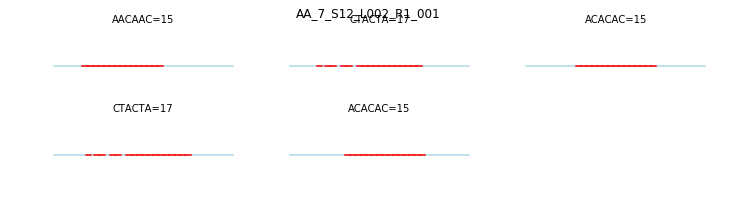

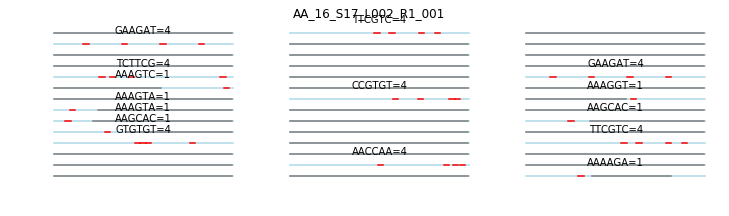

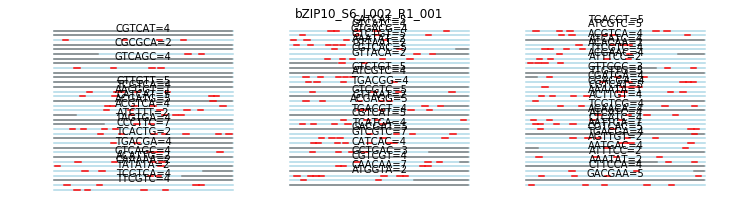

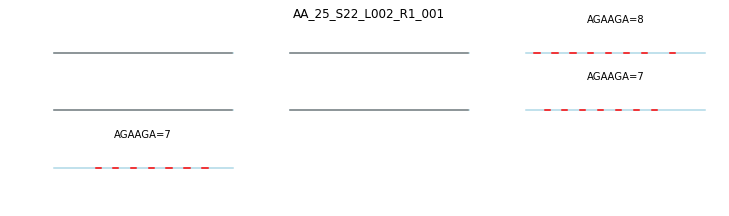

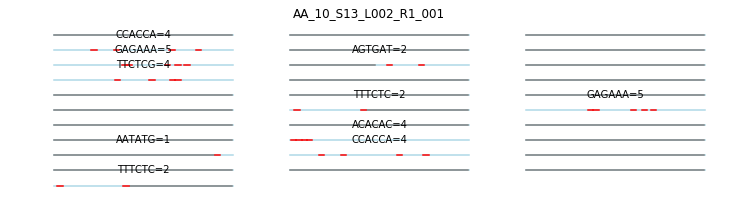

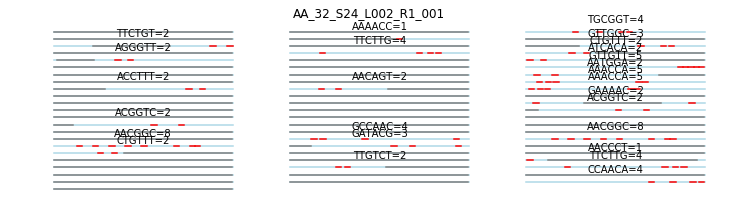

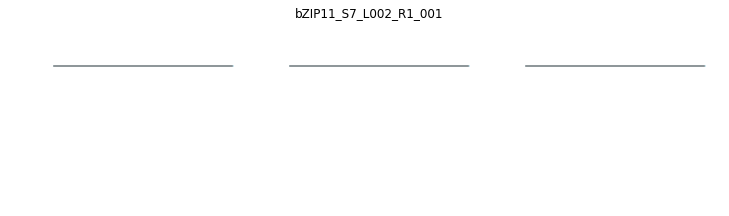

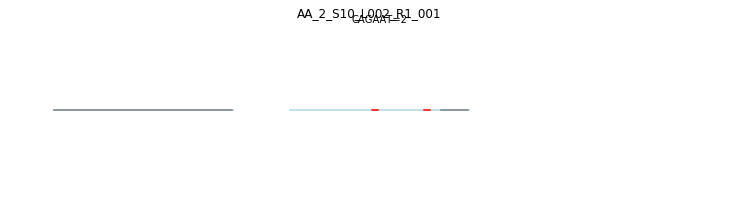

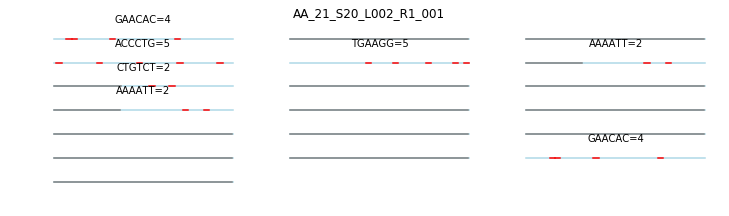

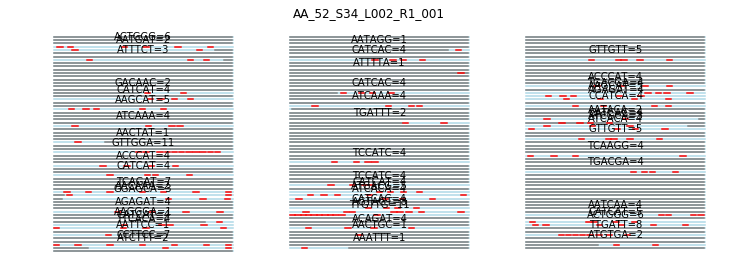

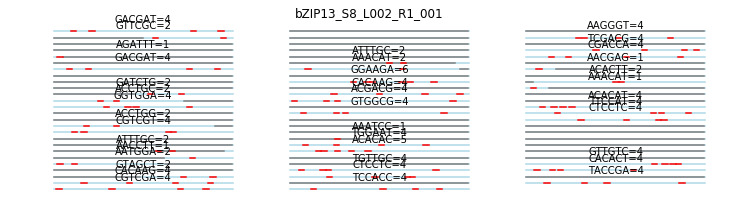

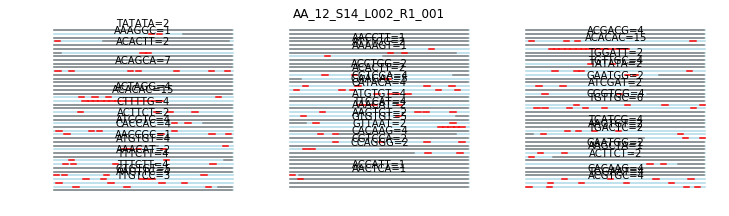

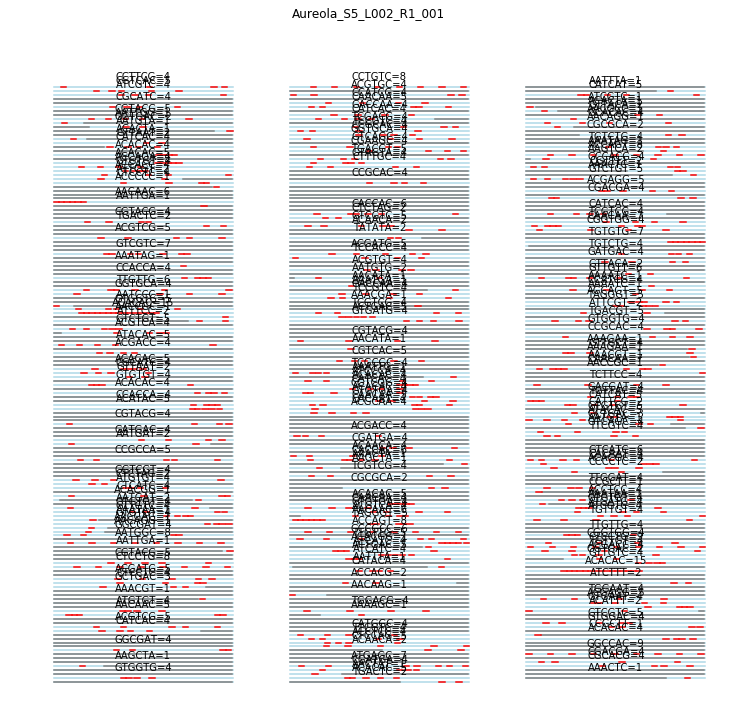

In [298]:
### Filter out tandem sequences 

# P of 6-mer show up in n base pair
# m time n/(4^6)^m - 1 time 0.12 -2 times 0.3e-3 -3 times 7.3e-9



for item in Sub_sample_list:
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        print(item)
        fasta_file = os.environ['file_path']+'/fasta/'+os.environ['sample_ID']+'.fasta.nodup'
        Tandem_filter(fasta_file,k = 6,k_max = 4)    

In [299]:
'''-objfun ce - This objective function scores motifs based on their enrichment in the central regions of the primary sequences, which must all be of same the length. (See option -cefrac, below.) 
The width and number of sites of each motif are determined using the binomial test. '''
# -mod anr/oops/zoops
# -ws The gap extension cost for creating the alignments used to trim the motif.

for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !meme $file_path/fasta/$sample_ID.fasta.nodup \
        -nmotifs 1 -minw 4 -maxw 12 -dna -mod oops -nostatus -p 6\
        -oc $file_path/GEM_BED/$sample_ID-meme

100%|██████████| 13/13 [06:12<00:00, 28.67s/it]


In [347]:
# If meme derived motif model was used
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !fimo -verbosity 1 --thresh 1e-3\
        -oc $file_path/GEM_BED/$sample_ID-fimo/ \
        $file_path/GEM_BED/$sample_ID-meme/meme.txt \
        $path/Genome_ref/PT_Chr_only.fa

100%|██████████| 13/13 [05:39<00:00, 26.08s/it]


In [345]:
# Convert gff to bed
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !convert2bed -i gff -o bed < $file_path/GEM_BED/$sample_ID-fimo/fimo.gff > $file_path/GEM_BED/$sample_ID-fimo/fimo.bed 

100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


In [307]:
def get_type(x):
    if len(x.split(','))>1:
        return 0
    elif 'MACS' in x:
        return 1
    elif 'GEM' in x:
        return 2
    else:
        return -1

In [308]:
# Import the library
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [352]:
# Compare motif to peaks

venn_set = {}
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        try:
            !bedtools intersect -wo -a $file_path/GEM_BED/$sample_ID-fimo/fimo.bed -b $file_path/compare_bed/$sample_ID.MACS.bed \
            > $file_path/compare_bed/$sample_ID.MACS_peak.bed
            !bedtools intersect -wo -a $file_path/GEM_BED/$sample_ID-fimo/fimo.bed -b $file_path/compare_bed/$sample_ID.GEM.bed \
            > $file_path/compare_bed/$sample_ID.GEM_peak.bed
            !bedtools intersect -wo -a $file_path/compare_bed/$sample_ID.MACS.bed -b $file_path/compare_bed/$sample_ID.GEM.bed \
            > $file_path/compare_bed/$sample_ID.compare_peak.bed
            !bedtools intersect -wo -a $file_path/GEM_BED/$sample_ID-fimo/fimo.bed -b $file_path/compare_bed/$sample_ID.MACS.bed $file_path/compare_bed/$sample_ID.GEM.bed \
            > $file_path/compare_bed/$sample_ID.nohit_peak.bed

            df_MACS = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.MACS.bed',header = None)
            df_GEM = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.GEM.bed',header = None)
            df_Motif = pd.read_table(os.environ['file_path']+'/GEM_BED/'+os.environ['sample_ID']+'-fimo/fimo.bed',header = None) 

            df_compare_MACS_peak = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.MACS_peak.bed',header = None)
            df_compare_GEM_peak = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.GEM_peak.bed',header = None)
            df_compare = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.compare_peak.bed',header = None)

            # compare all three 
            df_compare_motif = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.nohit_peak.bed',header = None)

            df_summary = pd.DataFrame(df_compare_motif.groupby(3)[14].apply(lambda x: "%s" % ', '.join(x)))
            df_summary.columns=['hit']
            df_summary.index.name = 'peak'
            df_summary['type'] = df_summary['hit'].apply(lambda x:get_type(x))


            # Unique to MACS
            MACS_only = len(df_MACS)-len(df_compare)-len(df_compare_MACS_peak)+len(df_summary[df_summary['type'] == 0])
            # Unique to GEM
            GEM_only = len(df_GEM)-len(df_compare)-len(df_compare_GEM_peak)+len(df_summary[df_summary['type'] == 0])
            # Unique to MOTIF
            MOTIF_only = len(df_Motif) - len(df_compare_MACS_peak) - len(df_compare_GEM_peak) + len(df_summary[df_summary['type'] == 0])

            # GEM overlap MACS only
            GEM_MACS_only = len(df_compare) - len(df_summary[df_summary['type'] == 0])
            # MACS overlap MOTIF only
            MACS_MOTIF_only = len(df_summary[df_summary['type'] == 1])
            # GEM overlap MOTIF only
            GEM_MOTIF_only = len(df_summary[df_summary['type'] == 2])

            # All overlap
            All_overlay = len(df_summary[df_summary['type'] == 0])   

            venn_set[item] = [MACS_only, GEM_only, GEM_MACS_only, MOTIF_only,MACS_MOTIF_only,GEM_MOTIF_only,All_overlay]
        except:
            continue

100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


In [360]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

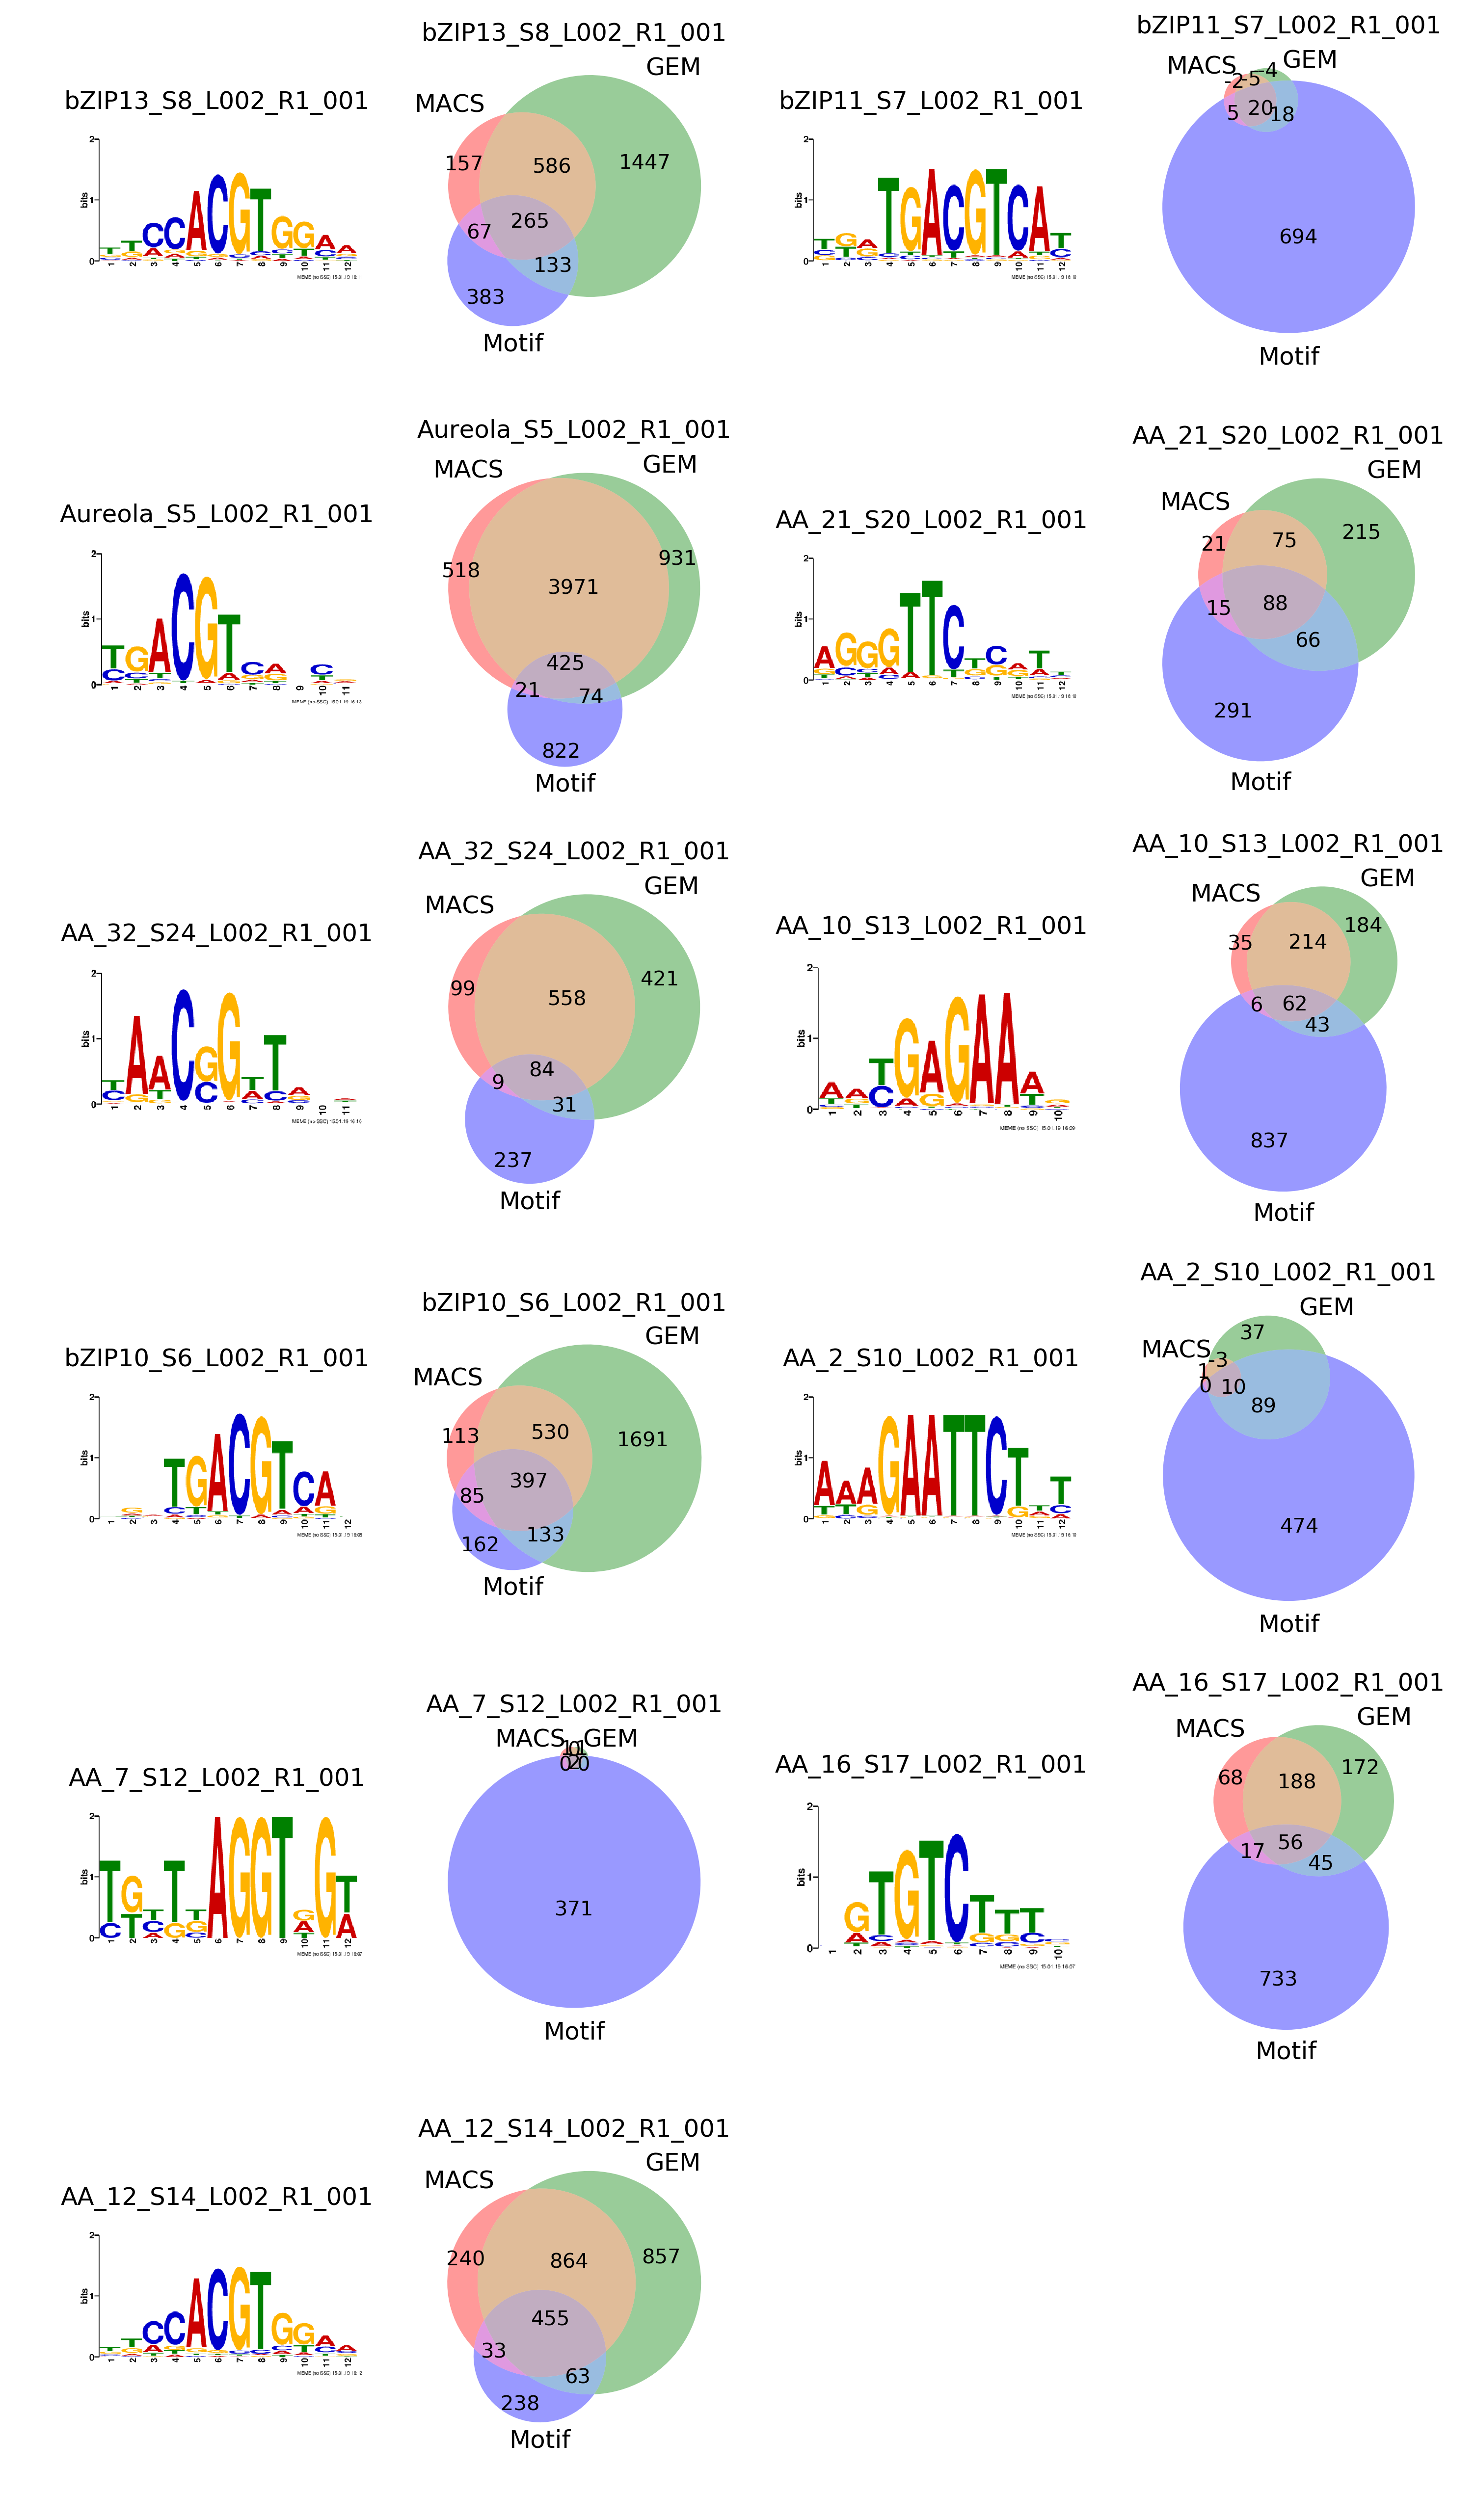

In [396]:
import matplotlib.image as mpimg

f,ax = plt.subplots(2*int(len(venn_set)/4)+2,4,figsize = (12,len(venn_set)*2),dpi = 300)
ax = ax.ravel()
[axi.set_axis_off() for axi in ax.ravel()]  


for ix,sets in enumerate(venn_set):
    ax[2*ix+1].set_title(str(sets))

    venn3(subsets = (venn_set[sets]),set_labels = ('MACS', 'GEM', 'Motif'),ax = ax[2*ix+1])
    ax[2*ix].set_title(str(sets))
    img = mpimg.imread(os.environ['file_path']+'/GEM_BED/'+sets+'-meme/logo1.png')
    ax[2*ix].imshow(img);



In [ ]:
    
'''    # Annotate the venn diagram with motif
    fn = get_sample_data(os.environ['file_path']+'/GEM_BED/'+sets+'-meme/logo1.png', asfileobj=False)
    arr_img = plt.imread(fn, format='png')

    imagebox = OffsetImage(arr_img, zoom=0.5)
    imagebox.image.axes = ax[2*ix]

    ab = AnnotationBbox(imagebox, xy=[0., 0.],
                        xybox=(100., 0.),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.3
                        )

    ax[2*ix].add_artist(ab)'''

In [ ]:
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        
        

In [241]:
!rm Result_$project_ID.zip
!zip -r -q -J -D Result_$project_ID.zip $file_path/GEM_BED/

In [5]:
def Tandem_filter(fasta_file,k = 6,k_max = 3):
    # k-mer based tandem filter 
    list_k_mer = [''.join(c) for c in itertools.product(['A','C','G','T'], repeat=k)]
    
    with open(fasta_file,'r') as handle:
        dict_fasta = SeqIO.to_dict(rec.upper() for rec in SeqIO.parse(handle,'fasta'))
    
    
    # Remove sequences that have tandem repeats
    Output_Seq = [] # Sequence that will be used for peak calling
    Clear_Seq = [] # Sequence that will be removed
    peak_loc = [] 
    kmer_list = []
    N_loc = []
    for seq in tqdm(dict_fasta):
        kmer_count = [dict_fasta[seq].seq.count(kmer) for kmer in list_k_mer]
        top_kmer = list_k_mer[kmer_count.index(max(kmer_count))]
        peaks = [kmer.start() for kmer in re.finditer(top_kmer, str(dict_fasta[seq].seq))]
        Ns = [kmer.start() for kmer in re.finditer(str('N'), str(dict_fasta[seq].seq))]
        if len(peaks)>=k_max or len(Ns)>1:
            peak_loc.append(peaks)
            Clear_Seq.append(dict_fasta[seq])
            kmer_list.append(top_kmer)
            N_loc.append(Ns)
        else:
            Output_Seq.append(dict_fasta[seq])
            
    # Plot all removed sequences for quality control        
    f,ax = plt.subplots(int(len(Clear_Seq)/3)+1,3,figsize = (12,max(3,int(len(Clear_Seq)/10))))
    [axi.set_axis_off() for axi in ax.ravel()]
    ax = ax.ravel()
    plt.suptitle(fasta_file.split('/')[-1].split('.')[0])
    for ix,seq in enumerate(Clear_Seq):
        ax[ix].plot([0,len(seq)],[0,0],'lightblue')
        if len(N_loc[ix])>1:
            ax[ix].plot([N_loc[ix][0],N_loc[ix][-1]],[0,0],'grey')
        for x in peak_loc[ix]:
            ax[ix].plot([x,x+k],[0,0],'r')
            if k_max > 2:
                ax[ix].set_title(kmer_list[ix]+'='+str(len(peak_loc[ix])),fontsize = 10)   
    with open(fasta_file[:-5]+'filtered.fasta','w') as output_handle:
        SeqIO.write(Output_Seq, output_handle, "fasta")